# Probablistic model building genetic algorithm

In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from notebooks.runAmber_kinn import get_uniform_ms, get_finkelstein_ms, get_data
%matplotlib inline

Using TensorFlow backend.


0.1.1-ga


In [3]:
# reload and re-train to full convergence
%run notebooks/reload

In [4]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [5]:
wd = "outputs/bak_20220228/KINN-wtCas9_cleave_rate_log-finkelstein-0/"
target = "wtCas9_cleave_rate_log"

res = get_data(target=target)
# unpack data tuple
x_train, y_train, x1, y1, x_test, y_test, x2, y2 = res

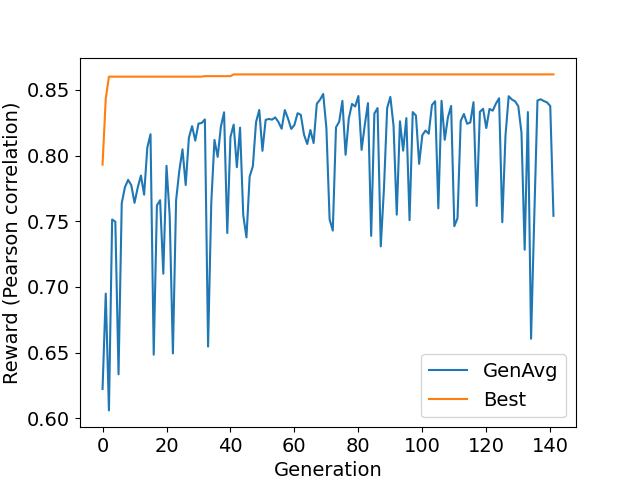

In [6]:
from IPython.display import Image

Image(filename=os.path.join(wd, "reward_vs_time.png"), width=400)

## Vis Search Stats

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


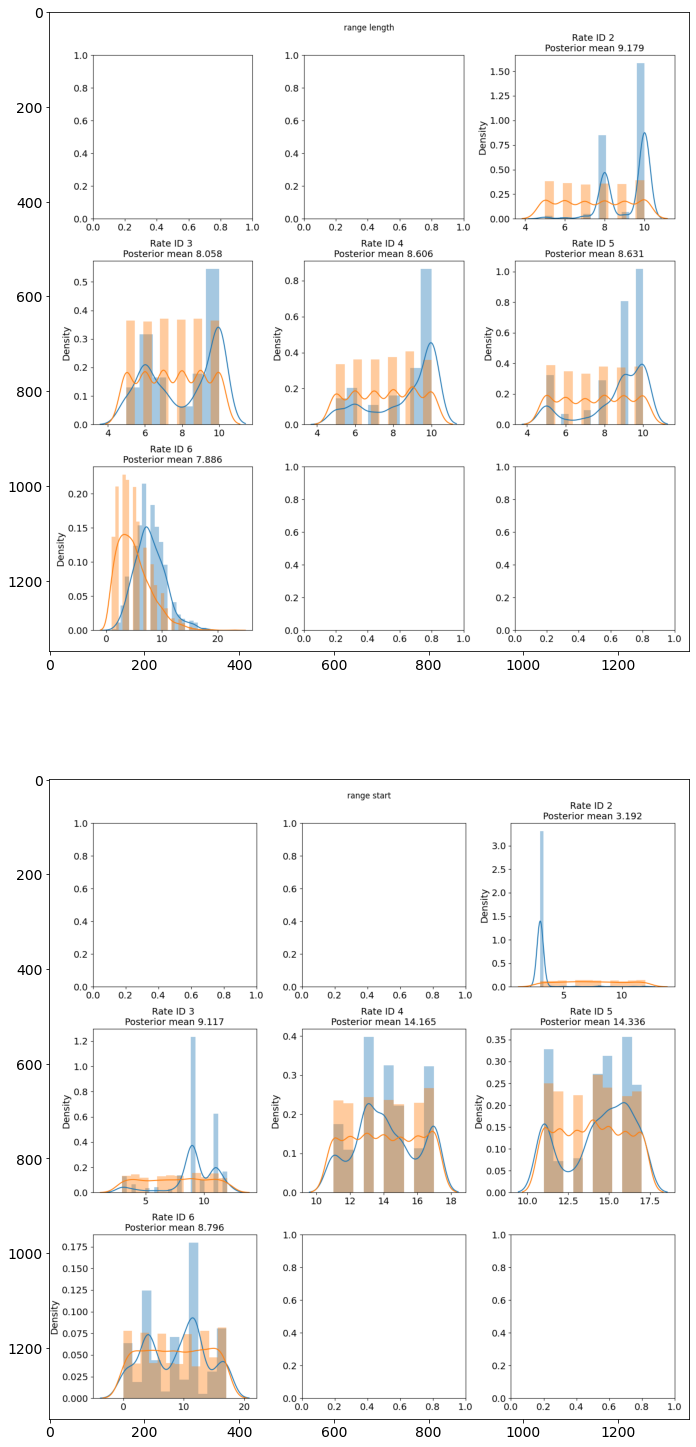

In [7]:
import matplotlib.image as mpimg

plt.figure(figsize=(40,40))
columns = 1
excl = ['reward_vs_time.png', 'kernel_size.png']
images = [mpimg.imread(os.path.join(wd,x)) for x in sorted([x for x in os.listdir(wd) \
                                                            if x.endswith("png") and not x in excl])]
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

## Reload Model

In [8]:
kinn_model_space = get_finkelstein_ms()
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [9]:
mb = reload_from_dir(wd, replace_conv_by_fc=True, n_channels=9)
model = mb.model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0_3 (InputLayer)          [(None, 3, 9)]       0                                            
__________________________________________________________________________________________________
input_3_13 (InputLayer)         [(None, 10, 9)]      0                                            
__________________________________________________________________________________________________
input_11_17 (InputLayer)        [(None, 6, 9)]       0                                            
__________________________________________________________________________________________________
input_15_24 (InputLayer)        [(None, 9, 9)]       0                                            
______________________________________________________________________________________________

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


spearman SpearmanrResult(correlation=0.5228624878014334, pvalue=0.0)
pearson (0.5368426671937933, 0.0)


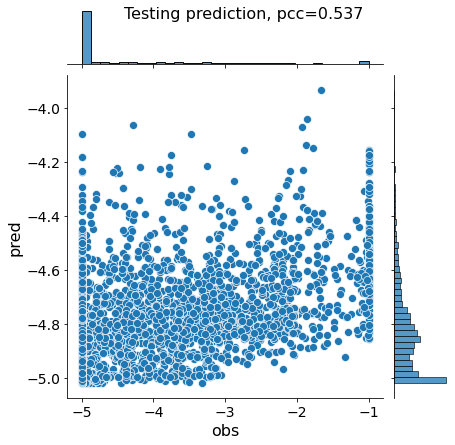

In [10]:
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)

y_hat = model.predict(x_test_b).flatten()
test_pcc_old = ss.pearsonr(y_hat, y_test)[0]

h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p_old = ss.pearsonr(y_hat, y_test)
print("pearson", p_old)
h.fig.suptitle("Testing prediction, pcc=%.3f"%test_pcc_old, fontsize=16)
plt.show()


## Retrain and Check for Improvements
Don't run, just overfitting

checkpointer = ModelCheckpoint(
    filepath=os.path.join(wd,"bestmodel_retrain.h5"), mode='min', verbose=0, save_best_only=True,
    save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=15,
    verbose=0)

hist = model.fit(x_train_b, y_train,
          batch_size=32,
          validation_data=(x_test_b, y_test),
          callbacks=[checkpointer, earlystopper],
          epochs=500, verbose=0)
model.load_weights(os.path.join(wd,"bestmodel_retrain.h5"))


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

y_hat = model.predict(x_test_b).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

if p_old[0] >= p[0]:
    model.load_weights(os.path.join(wd, "AmberSearchBestModel.h5"))
    print("retraining is overfitting; load from amber search")
else:
    print("retraining improves the model")

# Getting Kinetic Rates from the Model

In [11]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [0, 3], 'kernel_size': 3, 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [0, 3], 'kernel_size': 3, 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [3, 13], 'kernel_size': 3, 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 10, 'template': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [11, 17], 'kernel_size': 3, 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 11, 'RANGE_D': 6, 'template': None}",
 "{'name': 'k_23', 'state_list': ['2', '3'], 'input_range': [15, 25], 'kernel_size': 7, 'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'padding': 'same', 'EDGE'

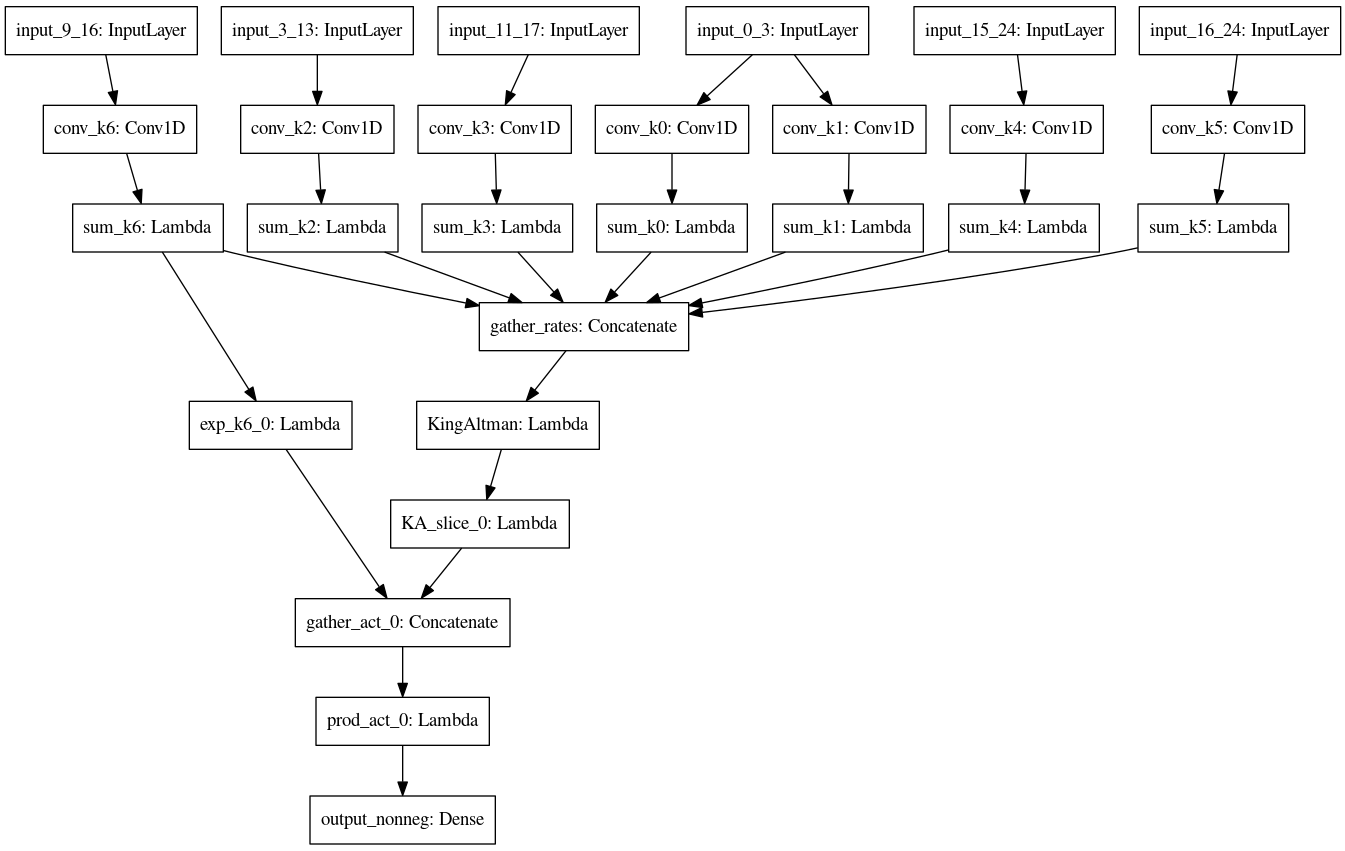

In [12]:
tf.keras.utils.plot_model(model)

In [13]:
layer_dict = {l.name:l for l in model.layers}

In [14]:
layer_dict['output_nonneg'].get_weights()

[array([[2.6293826]], dtype=float32), array([-5.0198174], dtype=float32)]

In [15]:
# confirmed - is aligned from rate 0 to rate N
rate_mod = tf.keras.models.Model(inputs=model.inputs, outputs=layer_dict['gather_rates'].output) 
#rate_mod = tf.keras.models.Model(inputs=model.inputs, outputs=
#                                 [layer_dict["conv_k%i"%k].output for k in range(7)])

In [16]:
outs = rate_mod.predict([x_test_b[i] for i in range(len(x_test_b))])
outs.squeeze()

array([[ 0.5656782 ,  1.0493703 ,  0.41821346, ...,  0.4330335 ,
         0.36601132,  0.07654703],
       [ 0.5656782 ,  1.0493703 , -0.5860343 , ...,  0.4330335 ,
         0.36601132,  0.7361445 ],
       [ 0.5656782 ,  1.0493703 ,  0.41821346, ...,  0.484612  ,
         0.8632884 ,  0.1433658 ],
       ...,
       [-0.58064693,  3.0843294 , -0.16853943, ...,  0.4330335 ,
         0.36601132,  0.7361445 ],
       [ 0.52696466,  0.81138754,  0.41821346, ...,  0.2687173 ,
         0.36601132,  0.9349232 ],
       [ 0.5656782 ,  1.0493703 , -0.09855363, ..., -0.7000061 ,
         1.6445632 ,  0.7361445 ]], dtype=float32)

In [17]:
outs = pd.DataFrame(outs, columns=['k_%i'%i for i in range(outs.shape[1])])
outs['obs_cleavage_log10'] = y_test
outs['pred_cleavage_log10'] = model.predict(x_test_b).flatten()

In [18]:
outs.tail(10).round(3)

,k_0,k_1,k_2,k_3,k_4,k_5,k_6,obs_cleavage_log10,pred_cleavage_log10
5594,0.566,1.049,0.216,0.378,0.261,1.030,0.729,-4.176,-4.771
5595,0.566,1.049,-0.117,0.378,0.121,1.284,0.736,-5.000,-4.863
5596,0.566,1.049,0.418,0.378,0.980,0.515,0.736,-1.020,-4.509
5597,0.566,1.049,0.289,0.378,0.211,1.119,0.387,-3.719,-4.815
5598,0.566,1.049,-0.169,0.378,0.322,1.141,0.736,-5.000,-4.834
5599,0.566,1.049,-0.098,0.665,0.433,0.366,-0.049,-5.000,-4.848
5600,0.566,1.049,-0.595,0.378,1.266,0.671,0.736,-4.246,-4.760
5601,-0.581,3.084,-0.169,0.378,0.433,0.366,0.736,-5.000,-4.999
5602,0.527,0.811,0.418,0.771,0.269,0.366,0.935,-1.000,-4.678
5603,0.566,1.049,-0.099,1.048,-0.700,1.645,0.736,-5.000,-4.982


In [19]:
outs.to_csv(os.path.join(wd, "rates_df.tsv"), sep="\t", index=False)

# DO NOT RUN BELOW

In [20]:
# (x_train_b[2][1] * w).sum(axis=1) + b

In [21]:
# w=layer_dict['conv_k2'].get_weights()[0].squeeze()
# b=layer_dict['conv_k2'].get_weights()[1].squeeze()
# print(b)
# np.around(w,2)

In [22]:
# np.around(layer_dict['conv_k1'].get_weights()[0],3)

In [23]:
# x_test_b = mb.blockify_seq_ohe(x_test)
# y_hat = model.predict(x_test_b).flatten()
# y_hat = np.clip(y_hat, -5, -1)
# h = sns.jointplot(y_test, y_hat)
# h.set_axis_labels("obs", "pred", fontsize=16)
# print("spearman", ss.spearmanr(y_hat, y_test))
# p = ss.pearsonr(y_hat, y_test)
# print("pearson", p)
# h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)